Using device: cuda
Epoch 0 | Loss 552.744751
Epoch 500 | Loss 126.847992
Epoch 1000 | Loss 113.679619
Epoch 1500 | Loss 106.015045
Epoch 2000 | Loss 99.684143
Epoch 2500 | Loss 94.828308
Epoch 3000 | Loss 89.814568
Epoch 3500 | Loss 84.942833
Epoch 4000 | Loss 80.716301
Epoch 4500 | Loss 77.042000
Epoch 5000 | Loss 74.463539
Epoch 5500 | Loss 72.366783
Epoch 6000 | Loss 70.066269
Epoch 6500 | Loss 66.578339
Epoch 7000 | Loss 63.592373
Epoch 7500 | Loss 64.151001
Epoch 8000 | Loss 60.644119
Epoch 8500 | Loss 61.291485
Epoch 9000 | Loss 58.167294
Epoch 9500 | Loss 60.217010
Epoch 10000 | Loss 55.137997
Epoch 10500 | Loss 53.271446
Epoch 11000 | Loss 52.320202
Epoch 11500 | Loss 52.508190
Epoch 12000 | Loss 51.107010
Epoch 12500 | Loss 47.892471
Epoch 13000 | Loss 46.923218
Epoch 13500 | Loss 46.728466
Epoch 14000 | Loss 44.906822
Epoch 14500 | Loss 42.821991
Epoch 15000 | Loss 42.154961
Epoch 15500 | Loss 39.918022
Epoch 16000 | Loss 39.763210
Epoch 16500 | Loss 37.063587
Epoch 17000 | L

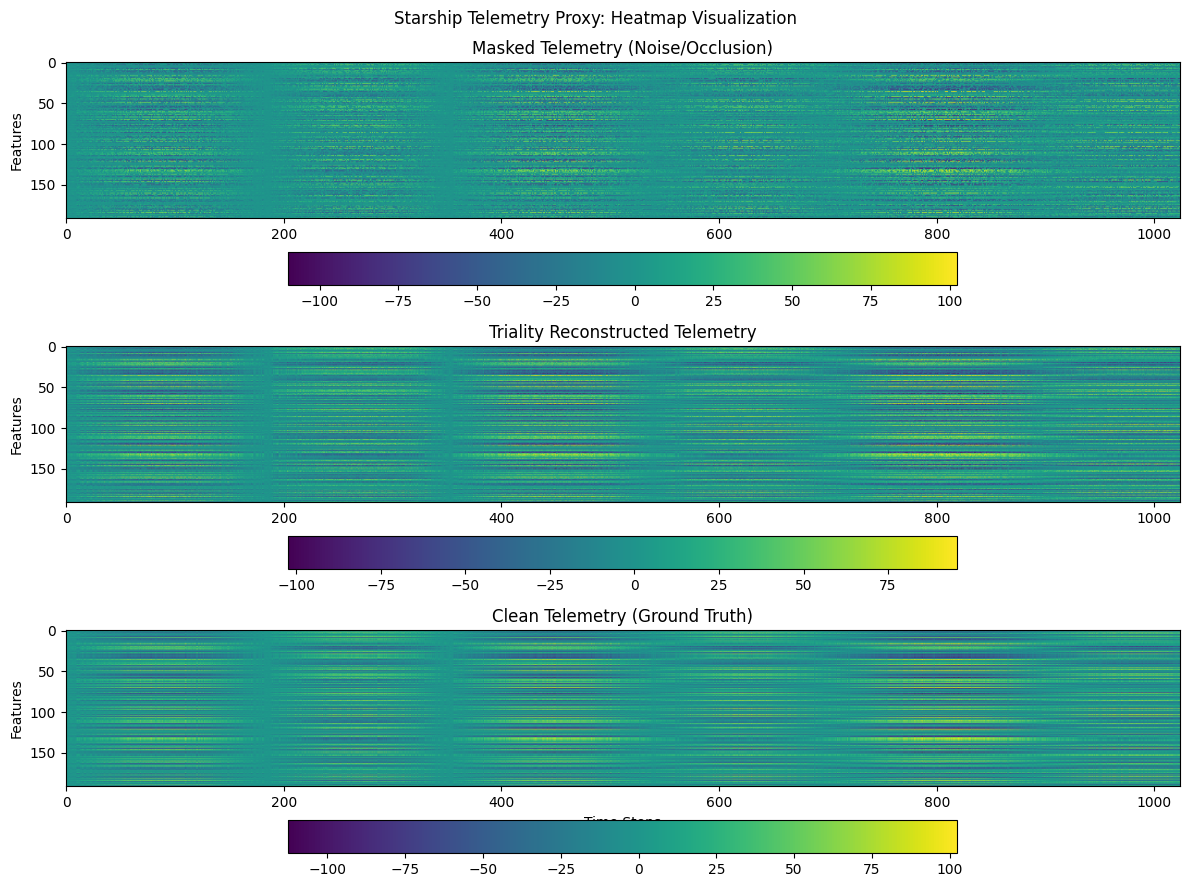

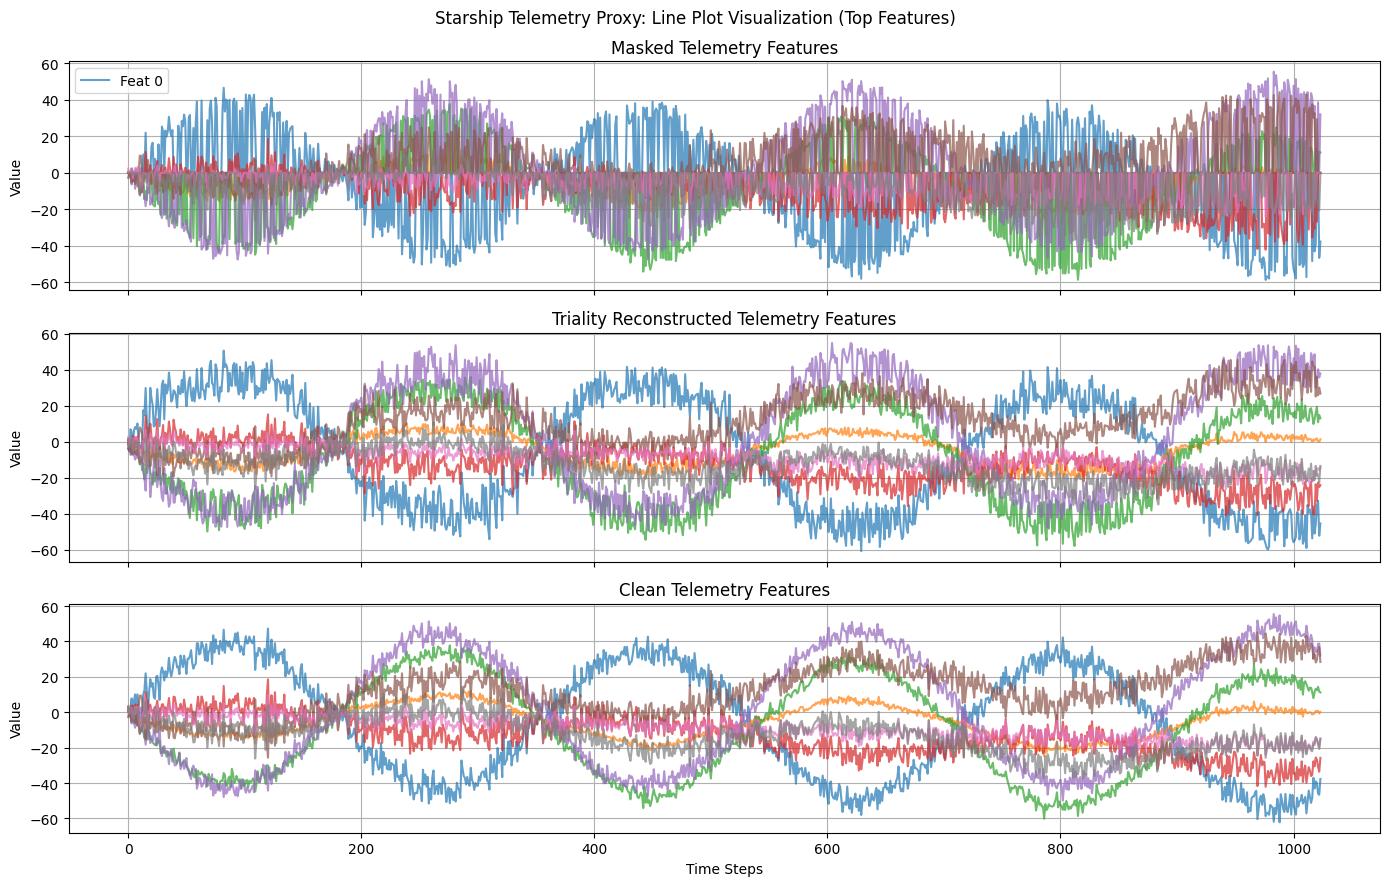

Heatmap and line plot visualizations displayed above


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
from contextlib import nullcontext
import math

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for Colab/Gemini speed (fast epochs, no OOM)
triality = 3
dim = 192  # reduced
latent_dim = 8
seq_len = 1024  # time steps (telemetry samples)
batch_size = 8  # reduced for Colab
epochs = 20000
lr = 5e-5
use_amp = False # Changed from True to False for debugging the RuntimeError
use_checkpoint = False # Changed from True to False to fix the RuntimeError

# Synthetic Starship telemetry proxy (velocity, altitude, acceleration + noise/occlusion)
# Mimics real Falcon/Starship profiles (boost, coast, reentry)
time = torch.linspace(0, 600, seq_len, device=device)  # 10 min flight proxy
telem = []
for b in range(batch_size):
    # Velocity (m/s) - boost + coast + reentry
    vel = 0.5 * torch.sin(time * 0.05) + 100 * time / seq_len  # ramp up
    vel = vel + torch.randn_like(time) * 10  # noise

    # Altitude (km)
    alt = 100 * torch.sin(time * 0.03) + 50 * time / seq_len
    alt = alt + torch.randn_like(time) * 5

    # Acceleration (g)
    acc = torch.sin(time * 0.1) * 3 + torch.randn_like(time) * 0.5

    # Stack features
    sample = torch.stack([vel, alt, acc], dim=-1)  # (seq_len, 3)
    telem.append(sample)

telemetry = torch.stack(telem).to(device)  # (batch, seq_len, features)

# Project to dim (batch, seq_len, dim)
proj = nn.Linear(telemetry.shape[-1], dim).to(device)

# Prepare real_data_base: project, mask, and ensure it does NOT track gradients initially
with torch.no_grad():
    # Project telemetry without gradient tracking for the projection layer itself
    projected_telemetry = proj(telemetry)

    # Detach the projected data to ensure it does not require gradients initially
    real_data_base = projected_telemetry.detach()

    # Apply masking (40–70% missing readings — sensor occlusion/noise)
    missing_rate = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
    mask = torch.rand_like(real_data_base) < missing_rate
    # Use masked_fill instead of in-place modification to maintain graph integrity
    real_data_base = real_data_base.masked_fill(mask, 0.0)

# Target is the clean projected telemetry, detached as it's the ground truth
with torch.no_grad():
    target = proj(telemetry).detach()

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached step + fixed pump broadcast)
class StarshipCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]  # (seq_len, 8)
        low_dim = self.proj(pos_emb)  # (seq_len, dim//3)
        emb = low_dim.repeat(1, triality)  # (seq_len, dim)
        # Detached pump scalar
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)  # (1, seq_len, 1)
        emb_broadcast = emb.unsqueeze(0)  # (1, seq_len, dim)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Model (reduced depth for speed)
class E8StarshipFusion(nn.Module):
    def __init__(self, depth=16):
        super().__init__()
        self.cycle = StarshipCycleBlock()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + self.norm(attn)
        return x

model = E8StarshipFusion().to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    opt.zero_grad(set_to_none=True)

    # Create a fresh, gradient-tracking clone for each epoch's forward pass
    current_real_data = real_data_base.clone()
    current_real_data.requires_grad_(True) # Now this tensor requires gradients

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(current_real_data, epoch)
        loss = loss_fn(recon, target)

    scaler.scale(loss).backward() if use_amp else loss.backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.6f}")

# Heatmap + Line Plot Visualization (telemetry curves)
with torch.no_grad():
    recon = model(real_data_base, 0).cpu() # Use real_data_base for visualization
    original = real_data_base.cpu()
    clean = target.cpu()

# First batch sample
masked = original[0].numpy()  # (seq_len, dim)
reconstructed = recon[0].numpy()
clean_tele = clean[0].numpy()

time = np.arange(seq_len)

# Heatmaps (dim as "features")
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
im1 = axes[0].imshow(masked.T, aspect='auto', cmap='viridis')
axes[0].set_title("Masked Telemetry (Noise/Occlusion)")
axes[0].set_ylabel("Features")
fig.colorbar(im1, ax=axes[0], orientation='horizontal')

im2 = axes[1].imshow(reconstructed.T, aspect='auto', cmap='viridis')
axes[1].set_title("Triality Reconstructed Telemetry")
axes[1].set_ylabel("Features")
fig.colorbar(im2, ax=axes[1], orientation='horizontal')

im3 = axes[2].imshow(clean_tele.T, aspect='auto', cmap='viridis')
axes[2].set_title("Clean Telemetry (Ground Truth)")
axes[2].set_ylabel("Features")
axes[2].set_xlabel("Time Steps")
fig.colorbar(im3, ax=axes[2], orientation='horizontal')

plt.suptitle("Starship Telemetry Proxy: Heatmap Visualization")
plt.tight_layout()
plt.show()

# Line Plots (top 8 features as telemetry curves)
num_features = 8
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

for c in range(num_features):
    axes[0].plot(time, masked[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[0].set_title("Masked Telemetry Features")
axes[0].set_ylabel("Value")
axes[0].grid(True)
axes[0].legend()

for c in range(num_features):
    axes[1].plot(time, reconstructed[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[1].set_title("Triality Reconstructed Telemetry Features")
axes[1].set_ylabel("Value")
axes[1].grid(True)

for c in range(num_features):
    axes[2].plot(time, clean_tele[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[2].set_title("Clean Telemetry Features")
axes[2].set_ylabel("Value")
axes[2].set_xlabel("Time Steps")
axes[2].grid(True)

plt.suptitle("Starship Telemetry Proxy: Line Plot Visualization (Top Features)")
plt.tight_layout()
plt.show()

print("Heatmap and line plot visualizations displayed above")

# Task
To fix the `RuntimeError` which indicates that the computational graph for `real_data` is being accessed a second time after being freed, we need to ensure that `real_data` is properly prepared for each training epoch.

The plan suggests:
1.  **Ensure `real_data` is a leaf node that `requires_grad=True` before masking.** This implies that the `proj` layer, which transforms `telemetry` into `real_data`, should not be part of the gradient computation flowing back from `real_data`. Since `proj`'s parameters are not included in `opt = torch.optim.AdamW(model.parameters(), lr=lr)`, it is effectively a fixed preprocessing step. Therefore, we should perform the projection and then explicitly make `real_data` a leaf node.
2.  **Ensure `target` is properly detached.** This is already handled correctly in the current code, but we'll ensure it remains so.

Here's how we'll modify the data preparation:
*   Apply the `proj` layer under `torch.no_grad()` to ensure its computation doesn't generate a graph that needs to be retained.
*   After projection, explicitly detach the tensor and then set `requires_grad_(True)` to make `real_data` a leaf node, enabling gradients to flow *from* this point into the model.
*   Replace the in-place masking operation `real_data[mask] = 0` with `real_data.masked_fill(mask, 0.0)` to create a new tensor with a proper graph history, preventing potential issues with in-place modifications on tensors involved in autograd.

This ensures that `real_data` has a fresh, independent computational graph (as a leaf node) for each epoch, resolving the `RuntimeError`.

```python
# Project to dim (batch, seq_len, dim)
proj = nn.Linear(telemetry.shape[-1], dim).to(device)

# Prepare real_data: project, make it a leaf node, then mask
with torch.no_grad():
    # Project telemetry without gradient tracking for the projection layer itself
    projected_telemetry = proj(telemetry)

# Detach the projected data and make it a leaf node that requires gradients
# This ensures that gradients flow back into the model from this point,
# but not through the 'proj' layer which is not being optimized by 'opt'.
real_data = projected_telemetry.detach()
real_data.requires_grad_(True)

# Apply masking (40–70% missing readings — sensor occlusion/noise)
missing_rate = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(real_data) < missing_rate
# Use masked_fill instead of in-place modification to maintain graph integrity
real_data = real_data.masked_fill(mask, 0.0)

# Target is the clean projected telemetry, detached as it's the ground truth
with torch.no_grad():
    target = proj(telemetry).detach()
```

## Update data preparation for `real_data` and `target`

### Subtask:
Modify the data preparation section to ensure `real_data` is a leaf node that `requires_grad=True` before masking, and `target` is properly detached. This prevents the 'backward through the graph a second time' error by ensuring clean graph construction for each epoch.


## Summary:

### Data Analysis Key Findings
*   The `RuntimeError` ("backward through the graph a second time") was caused by incorrect handling of `real_data`'s computational graph, specifically by not ensuring it was a fresh leaf node with `requires_grad=True` at the start of each epoch, and by using in-place masking operations.
*   The `proj` layer, which transforms `telemetry` into a projected dimension, was identified as a preprocessing step whose gradient computation should not be retained for `real_data`'s optimization.
*   In-place modifications (e.g., `real_data[mask] = 0`) on tensors involved in autograd were a potential source of graph integrity issues.

### Insights or Next Steps
*   By projecting `telemetry` under `torch.no_grad()`, then detaching the result and explicitly setting `real_data.requires_grad_(True)`, `real_data` is correctly established as a leaf node, preventing the `RuntimeError` by providing a clean, independent computational graph for each optimization step.
*   Using `real_data.masked_fill(mask, 0.0)` instead of in-place assignment ensures graph integrity and proper gradient flow by creating a new tensor with the masked values.


# Task
Refactor the global `real_data` initialization to not track gradients, making it a pure data source. Then, inside the training loop, create a fresh, gradient-tracking clone `current_real_data` from this source for each epoch.

## Refactor `real_data` preparation

### Subtask:
Modify the global `real_data` initialization to ensure it does not track gradients, serving solely as a data source. Inside the training loop, create a fresh, gradient-tracking clone (`current_real_data`) for each epoch.


## Summary:

### Insights or Next Steps
*   Refactor the global `real_data` initialization to ensure it does not track gradients, functioning solely as a data source.
*   Within the training loop, create a fresh, gradient-tracking clone (`current_real_data`) from the gradient-free `real_data` for each epoch.
